In [3]:
pip install -U scikit-learn # cog lab needs to install SK learn

Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.24.1)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U seaborn # cog lab needs to install updated seaborn

Requirement already up-to-date: seaborn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, validation_curve, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

# ignore convergence warning from GridSearchCV
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [6]:
df = pd.read_csv("clean_kaggle_data_2020.csv", low_memory=False)

## Data Cleaning

Step 1: Drop rows that does not have 29 responses, since this is a 39-questions-survey with some multiple selections question. If participants have more than 10 questions not answered, then the responses from them may not be representative.

In [7]:
df.dropna(thresh = 29)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,9991"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,Python,NaN,NaN,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"
10726,5461,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
10727,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
10728,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,NaN,SQL,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"


Step 2: Check the number of NaN values in every column. Keep columns that has less than 5000 NaN values. Since there are about 10000 rows, if half of the participants did not answer this questions, this question cannot be a significant feature to differentiate participants in model built later.

In [8]:
temp = df.copy() # make copy to re-cover dataframe quickly when mistakes are made.
temp.isnull().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q3                                         0
Q4                                         0
                                       ...  
Q35_B_Part_9                           10481
Q35_B_Part_10                           9048
Q35_B_OTHER                            10596
Q24_Encoded                                1
Q24_buckets                                1
Length: 357, dtype: int64

In [9]:
max_number_of_nas = 5000
temp = temp.loc[:, (temp.isnull().sum() <= max_number_of_nas)]
# temp.head()

Step 3: Re-check the NaN values in in processed columns. We replace the NaN values in the single answer multiple choice questions ('Q8', 'Q11', 'Q13', 'Q15', 'Q25', 'Q38') with the mode from each question.

In [10]:
temp.isnull().sum()

Time from Start to Finish (seconds)       0
Q1                                        0
Q2                                        0
Q3                                        0
Q4                                        0
Q5                                        0
Q6                                        0
Q7_Part_1                              2009
Q8                                      561
Q9_Part_1                              4289
Q11                                     561
Q13                                     561
Q14_Part_1                             3263
Q15                                     561
Q16_Part_1                             4092
Q17_Part_1                             3787
Q17_Part_2                             4835
Q20                                       0
Q21                                       0
Q22                                       0
Q23_Part_1                             4381
Q24                                       0
Q25                             

In [11]:
temp1 = temp.copy()

l = ['Q8', 'Q11', 'Q13', 'Q15', 'Q25', 'Q38']

for i in l:
    temp1 = temp1.fillna({i: temp1[i].mode().iat[0]})

# temp1.head()
# temp1.isnull().sum() # re-check NaN values

Step 4: Drop unnecessary row and columns. Drop the first row of the actual questions. Because we already have Q24 encoded, we do not need Q24 and Q24 buckets. The first column of completion time will be less likely relate to salary/compensation, higher salary people might finish survey in an more efficient way due to their working ability, but might also finish survey in very long time due to they are busy, so time to complete the survey cannot be a feature that has significant imapct on predicting salary.

In [12]:
# remove the first row of the questions
temp1 = temp1.iloc[1:] 

# drop the first column, Q24 and Q24_buckets
temp1.drop(temp1.columns[temp1.columns.get_loc("Time from Start to Finish (seconds)")], axis = 1, inplace = True)
temp1.drop(temp1.columns[temp1.columns.get_loc("Q24")], axis = 1, inplace = True)
temp1.drop(temp1.columns[temp1.columns.get_loc("Q24_buckets")], axis = 1, inplace = True)
# temp1.head()

Step 5: For the muti answers question, each column will only consist of one option and NaN values. So These questions will be encoded into either 1 represents that option and 0 represents NaN values.

In [13]:
temp1['Q7_Part_1'].replace({'Python': 1, np.nan: 0}, inplace=True)
temp1['Q9_Part_1'].replace({'Jupyter (JupyterLab, Jupyter Notebooks, etc) ': 1, np.nan: 0}, inplace=True)
temp1['Q14_Part_1'].replace({' Matplotlib ': 1, np.nan: 0}, inplace=True)
temp1['Q16_Part_1'].replace({'  Scikit-learn ': 1, np.nan: 0}, inplace=True)
temp1['Q17_Part_1'].replace({'Linear or Logistic Regression': 1, np.nan: 0}, inplace=True)
temp1['Q17_Part_2'].replace({'Decision Trees or Random Forests': 1, np.nan: 0}, inplace=True)
temp1['Q23_Part_1'].replace({'Analyze and understand data to influence product or business decisions': 1, np.nan: 0}, inplace=True)
# temp1.head(5) # double-check
# temp1.isnull().sum() # double-check

Step 6: One-hot encoding for all the single answer questions. In order to exmamine objective relationship between each factor, it is better to do one-hot encoding assuming no relationship between those answers rather then ordered encoding.

In [14]:
temp2 = temp1.copy()

col = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8','Q11','Q13','Q15','Q20','Q21','Q22', 'Q25','Q38']

# one-hot encoding
for i in col:
    d1 = pd.get_dummies(temp2[i],prefix=[i])
    temp2 = pd.concat([temp2, d1], axis=1)
# temp2.head()

In [15]:
# Drop the original columns.
for i in col:
    temp2.drop(temp2.columns[temp2.columns.get_loc(i)], axis = 1, inplace = True)

## Exploratory Analysis

We use the dataframe from the step before one-hot encoding for data visualization.

<Figure size 2400x1600 with 0 Axes>

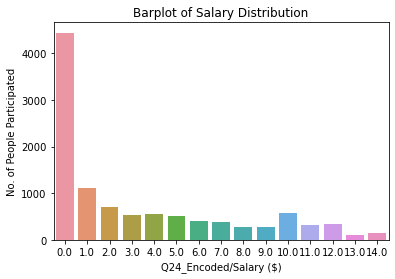

<Figure size 2400x1600 with 0 Axes>

In [16]:
# Plot 2.1
sns.countplot(x='Q24_Encoded',data=temp1)

plt.xlabel('Q24_Encoded/Salary ($)')
plt.ylabel('No. of People Participated')
plt.title('Barplot of Salary Distribution')
plt.figure(dpi=400)

There are more people located in the lower salary group and less people have high salary. The distribution is postively skewed similar to a pareto distribution.

<Figure size 2400x1600 with 0 Axes>

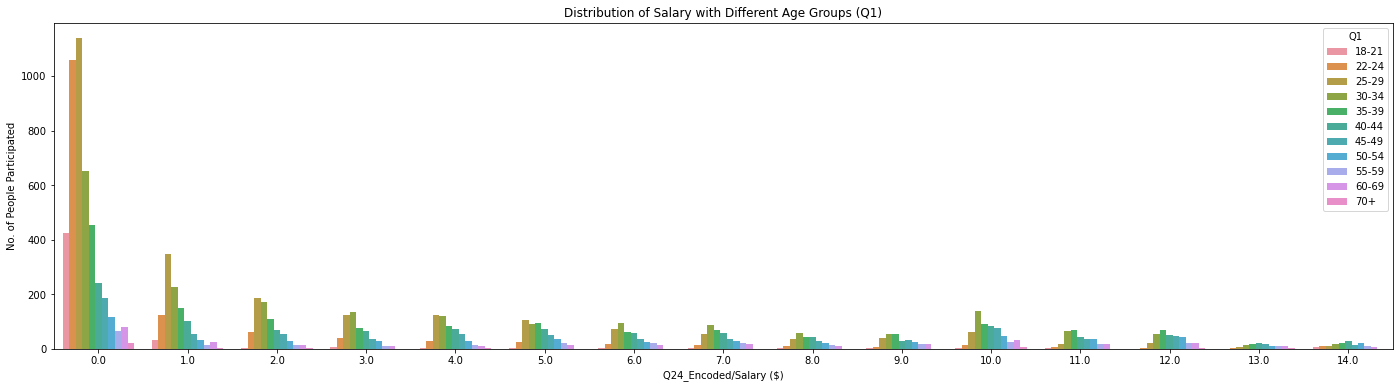

<Figure size 2400x1600 with 0 Axes>

In [17]:
# Plot 2.2
plt.figure(figsize=(24,6))

age_order = ['18-21','22-24','25-29', '30-34', '35-39', '40-44',
             '45-49','50-54','55-59','60-69','70+']

sns.countplot(x='Q24_Encoded', hue='Q1', data=temp1, hue_order = age_order)

plt.xlabel('Q24_Encoded/Salary ($)')
plt.ylabel('No. of People Participated')
plt.title('Distribution of Salary with Different Age Groups (Q1)')
plt.figure(dpi=400)

There are more people located in the middle age as salary goes higher. The distribution becomes less positively skewed as salary increases. This means middle age people have higher salary compared to the younger generation, which is reasonbale since younger generation are less experienced.

<Figure size 2400x1600 with 0 Axes>

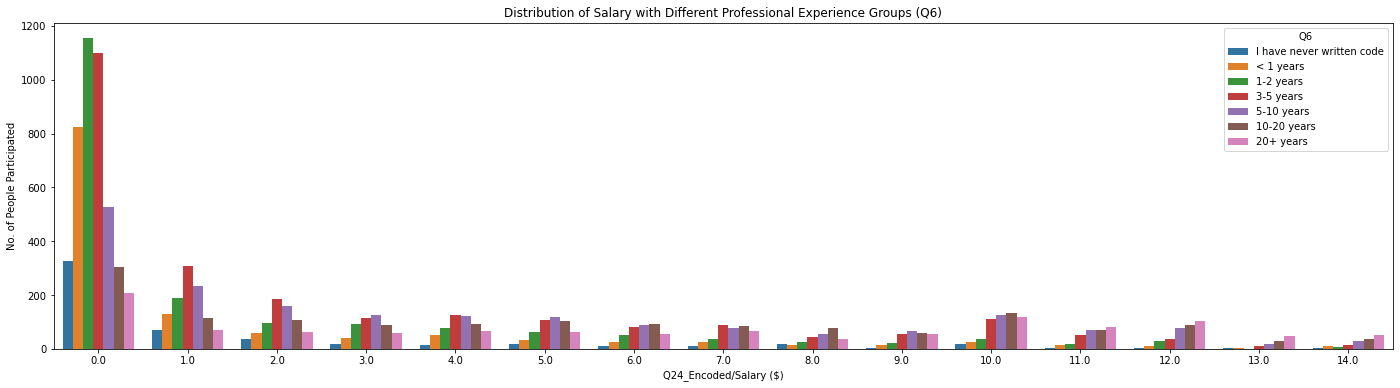

<Figure size 2400x1600 with 0 Axes>

In [18]:
# Plot 2.3
plt.figure(figsize=(24,6))

pe_order = ['I have never written code', '< 1 years', '1-2 years', '3-5 years','5-10 years', '10-20 years', 
        '20+ years']

ax = sns.countplot(x='Q24_Encoded', hue='Q6', data=temp1, hue_order = pe_order)

plt.xlabel('Q24_Encoded/Salary ($)')
plt.ylabel('No. of People Participated')
plt.title('Distribution of Salary with Different Professional Experience Groups (Q6)')
plt.figure(dpi=400)

There are more people with longer professional experience as salary increases.The distribution seems to be normal when salary is low and changes into negatively skewed as salary increases. It is reasonable that longer professional experience people has higher salary compared to people with less professional experience.

## Feature Selection

Step 1: if the column has more than 99% of same entries, then it is meaningless to become a feature since almost all the entries are basically the same. It is hard to become a significant feature later to differentiate between different participants to make accurate prediction on salary/compensation.

In [19]:
temp3 = temp2.copy()
leng = 0.99*temp3.shape[0]

l = np.where(temp3.apply(lambda x: x.value_counts().iloc[0], axis = 0) > leng)[0].tolist()
temp3.drop(temp3.columns[l], axis = 1, inplace = True)
# temp3.head(10)

Step 2: Because all the input and target variables are categorical, it is suitable to use chi-square contigency to check the correlation between each feature with Q24_encoded. Then, append p value for each feature, sort them from least to largest p and visualize the order of features. Drop the unsignificant features.

In [20]:
# Null Hypothesis (H0): There is no relationship between the variables and Q24_Encoded salary/compensation
# Alternative Hypothesis (H1): There is a relationship between variables and Q24_Encoded salary/compensation

chi2_check = []
p = []

# chi-square contigency between Q24_Encoded and each column from temp3.
chi2_check = temp3.apply(lambda x: chi2_contingency(pd.crosstab(temp3['Q24_Encoded'], x))[1], axis = 0) 
res = pd.DataFrame(data = [temp3.columns, chi2_check]).T # append p values
res.columns = ['Column', 'p']

res = res.sort_values(by=['p'], axis=0, ascending=True, inplace=False, kind='quicksort') # sort based on p-values
res.head(10)

,Column,p
43,['Q3']_United States of America,0
7,Q24_Encoded,0
113,"['Q25']_$100,000 or more ($USD)",8.69483e-217
28,['Q3']_India,5.09047e-190
9,['Q1']_22-24,3.47447e-160
92,['Q20']_0-49 employees,1.3111e-159
63,['Q6']_20+ years,2.51509e-143
107,['Q22']_We have well established ML methods (i...,4.37149e-143
91,['Q15']_Under 1 year,2.3912e-114
89,['Q15']_5-10 years,3.1826e-113


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121]),
 [Text(0, 0, "['Q3']_United States of America"),
  Text(1, 0, 'Q24_Encoded'),
  Text(2, 0, "['Q25']_$100,000 or more ($USD)"),
  Text(3, 0, "['Q3']_India"),
  Text(4, 0, "['Q1']_22-24"),
  Text(5, 0, "['Q20']_0-49 employees"),
  Text(6, 0, "['Q6']_20+ years"),
  Text(7, 0, "['Q22']_We have well established 

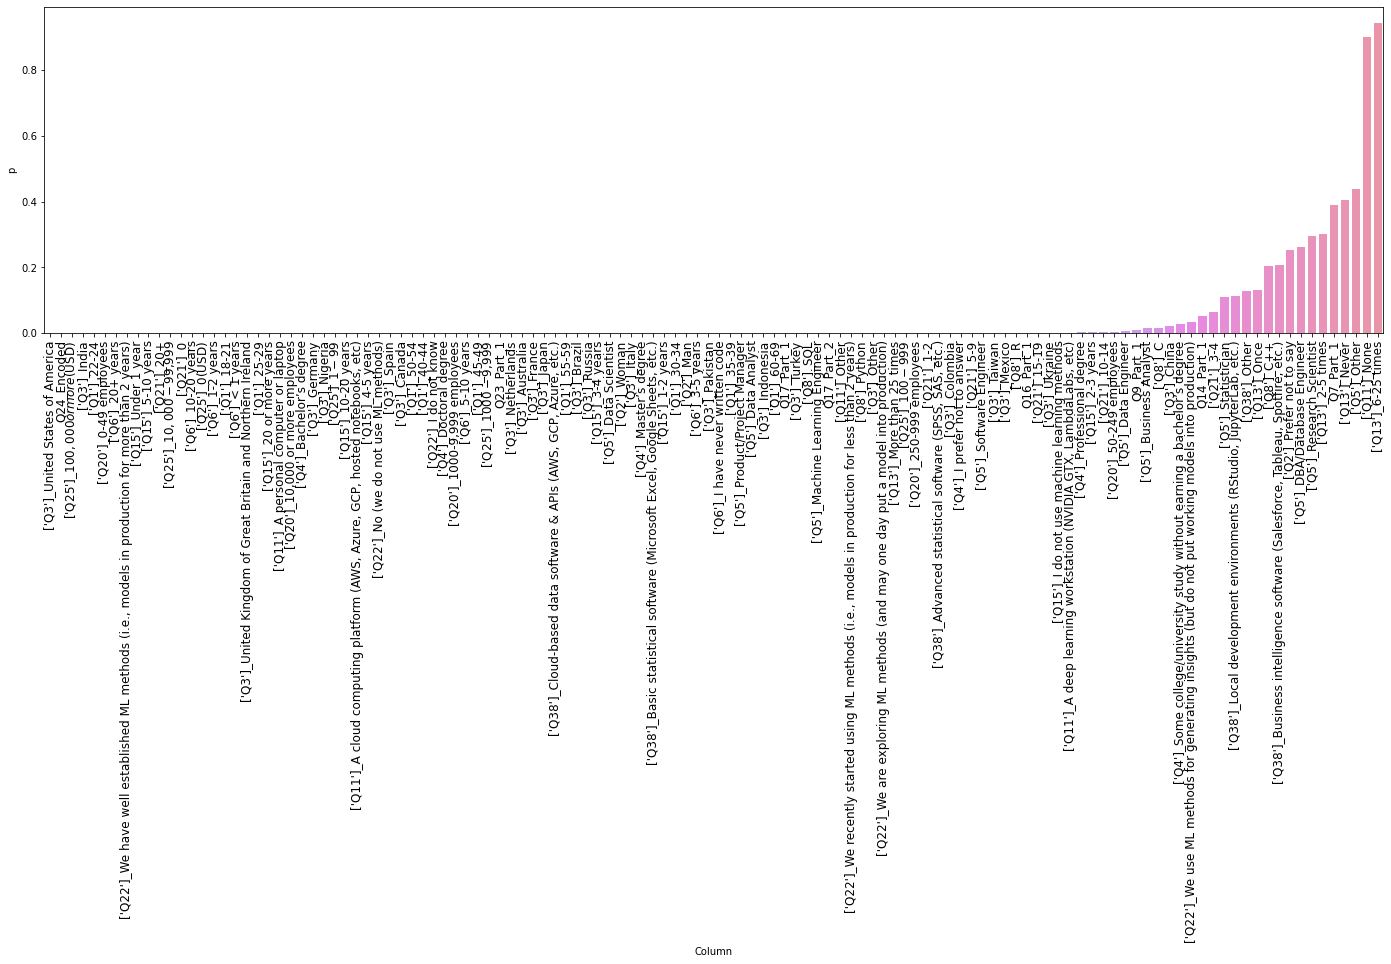

In [21]:
# Plot 2.4
# Plot features based on p-values from least to largest
plt.figure(figsize=(24,6))
ax = sns.barplot(x="Column", y="p", data=res)
plt.xticks(fontsize=12, rotation=90)

In [22]:
# find those unsignificant columns/features with p-value > 0.05
non_sig = []
non_sig = np.where(temp3.apply(lambda x: chi2_contingency(pd.crosstab(temp3['Q24_Encoded'], 
                                                                      x))[1], axis = 0) > 0.05)[0].tolist()

# remove those p-value are unsignificant >0.05, then we get 100 columns
temp4 = temp3.copy()    
temp4.drop(temp4.columns[non_sig], axis = 1, inplace = True)
# temp4.head()

Step 3: Because we cannot visualize how well the significant features are from the chi-square test, we decide to use chi-square statistic to select and visualize features based on score.

Feature 0: 9.235889
Feature 1: 10.721579
Feature 2: 17.673278
Feature 3: 26.026056
Feature 4: 56.058450
Feature 5: 275.248226
Feature 6: 475.048372
Feature 7: 182.195807
Feature 8: 63.417019
Feature 9: 72.332862
Feature 10: 148.386868
Feature 11: 108.838772
Feature 12: 125.664900
Feature 13: 135.182398
Feature 14: 66.700135
Feature 15: 12.771088
Feature 16: 75.770204
Feature 17: 128.539690
Feature 18: 90.756033
Feature 19: 194.681931
Feature 20: 28.528119
Feature 21: 31.836323
Feature 22: 118.387140
Feature 23: 153.428567
Feature 24: 488.108083
Feature 25: 65.329704
Feature 26: 80.498523
Feature 27: 109.066196
Feature 28: 34.281356
Feature 29: 114.323722
Feature 30: 158.497936
Feature 31: 39.639097
Feature 32: 71.186479
Feature 33: 86.711573
Feature 34: 159.531386
Feature 35: 27.533096
Feature 36: 56.632466
Feature 37: 25.447591
Feature 38: 243.875976
Feature 39: 1963.281804
Feature 40: 139.721718
Feature 41: 135.915431
Feature 42: 29.699376
Feature 43: 46.115556
Feature 44: 24.398083


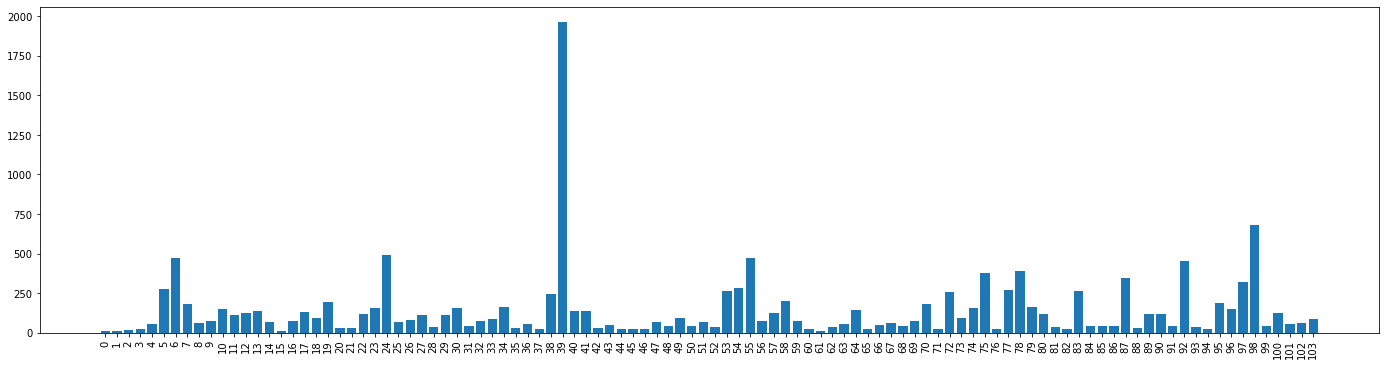

In [23]:
# Plot 2.5
temp5 = temp4.copy()

#separate features & target
y = temp5['Q24_Encoded']
temp5.drop(temp5.columns[temp5.columns.get_loc('Q24_Encoded')], axis = 1, inplace = True)
X = temp5

# format all X fields into string
X = X.astype(str)

# split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# feature selection - chi-square
def select_features(X_train, Y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Apply feature selection function
X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
plt.figure(figsize=(24,6))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(np.arange(0, len(fs.scores_), 1.0),fontsize=10, rotation = 90)
plt.show()

In [24]:
# Combine score with X train dataframes, sort based on score from highest to lowest
score = pd.DataFrame(data = [X_train.columns, fs.scores_]).T
score.columns = ['Column', 'score']
score = score.sort_values(by=['score'], axis=0, ascending=False, inplace=False, kind='quicksort')

score.head(25)

,Column,score
39,['Q3']_United States of America,1963.28
98,"['Q25']_$100,000 or more ($USD)",677.433
24,['Q3']_India,488.108
6,['Q1']_22-24,475.048
55,['Q6']_20+ years,469.906
92,['Q22']_We have well established ML methods (i...,452.846
78,['Q20']_0-49 employees,387.23
75,['Q15']_5-10 years,374.699
87,['Q21']_20+,342.852
97,"['Q25']_$10,000-$99,999",320.736


We can see that most of the features scored under 250.17. Thus, 250 is the cut-off of selecting features for model implementation in order to maintain a set of essential features and a medium level of model complexity. Another reason to keep 17 features is that there was a big gap in score between the 17th feature and 18th feature, one scored 243.876 and the latter one scored 199.892. Before the 17th feature, the big gap in the score is between the 2nd (677.433) and 3rd (488.108) features, but maintaining only 2 features to predict salary from 10000 people might not receive higher accuracy. After the 17th feature, no big gap occurs in the score. If we include features scored above 100, then 45 features need to be selected for the model which would increase model complexity. Thus, the cut-off occurs at the 17th feature for feature selection.

In [25]:
# select top 17
l = score.iloc[0:17,0].tolist() 

# drop the rest of the columns not in l
temp6 = temp4.copy()

l.append('Q24_Encoded')

for i in temp6.columns:
    if i not in l:
        temp6.drop(temp6.columns[temp6.columns.get_loc(i)], axis = 1, inplace = True)

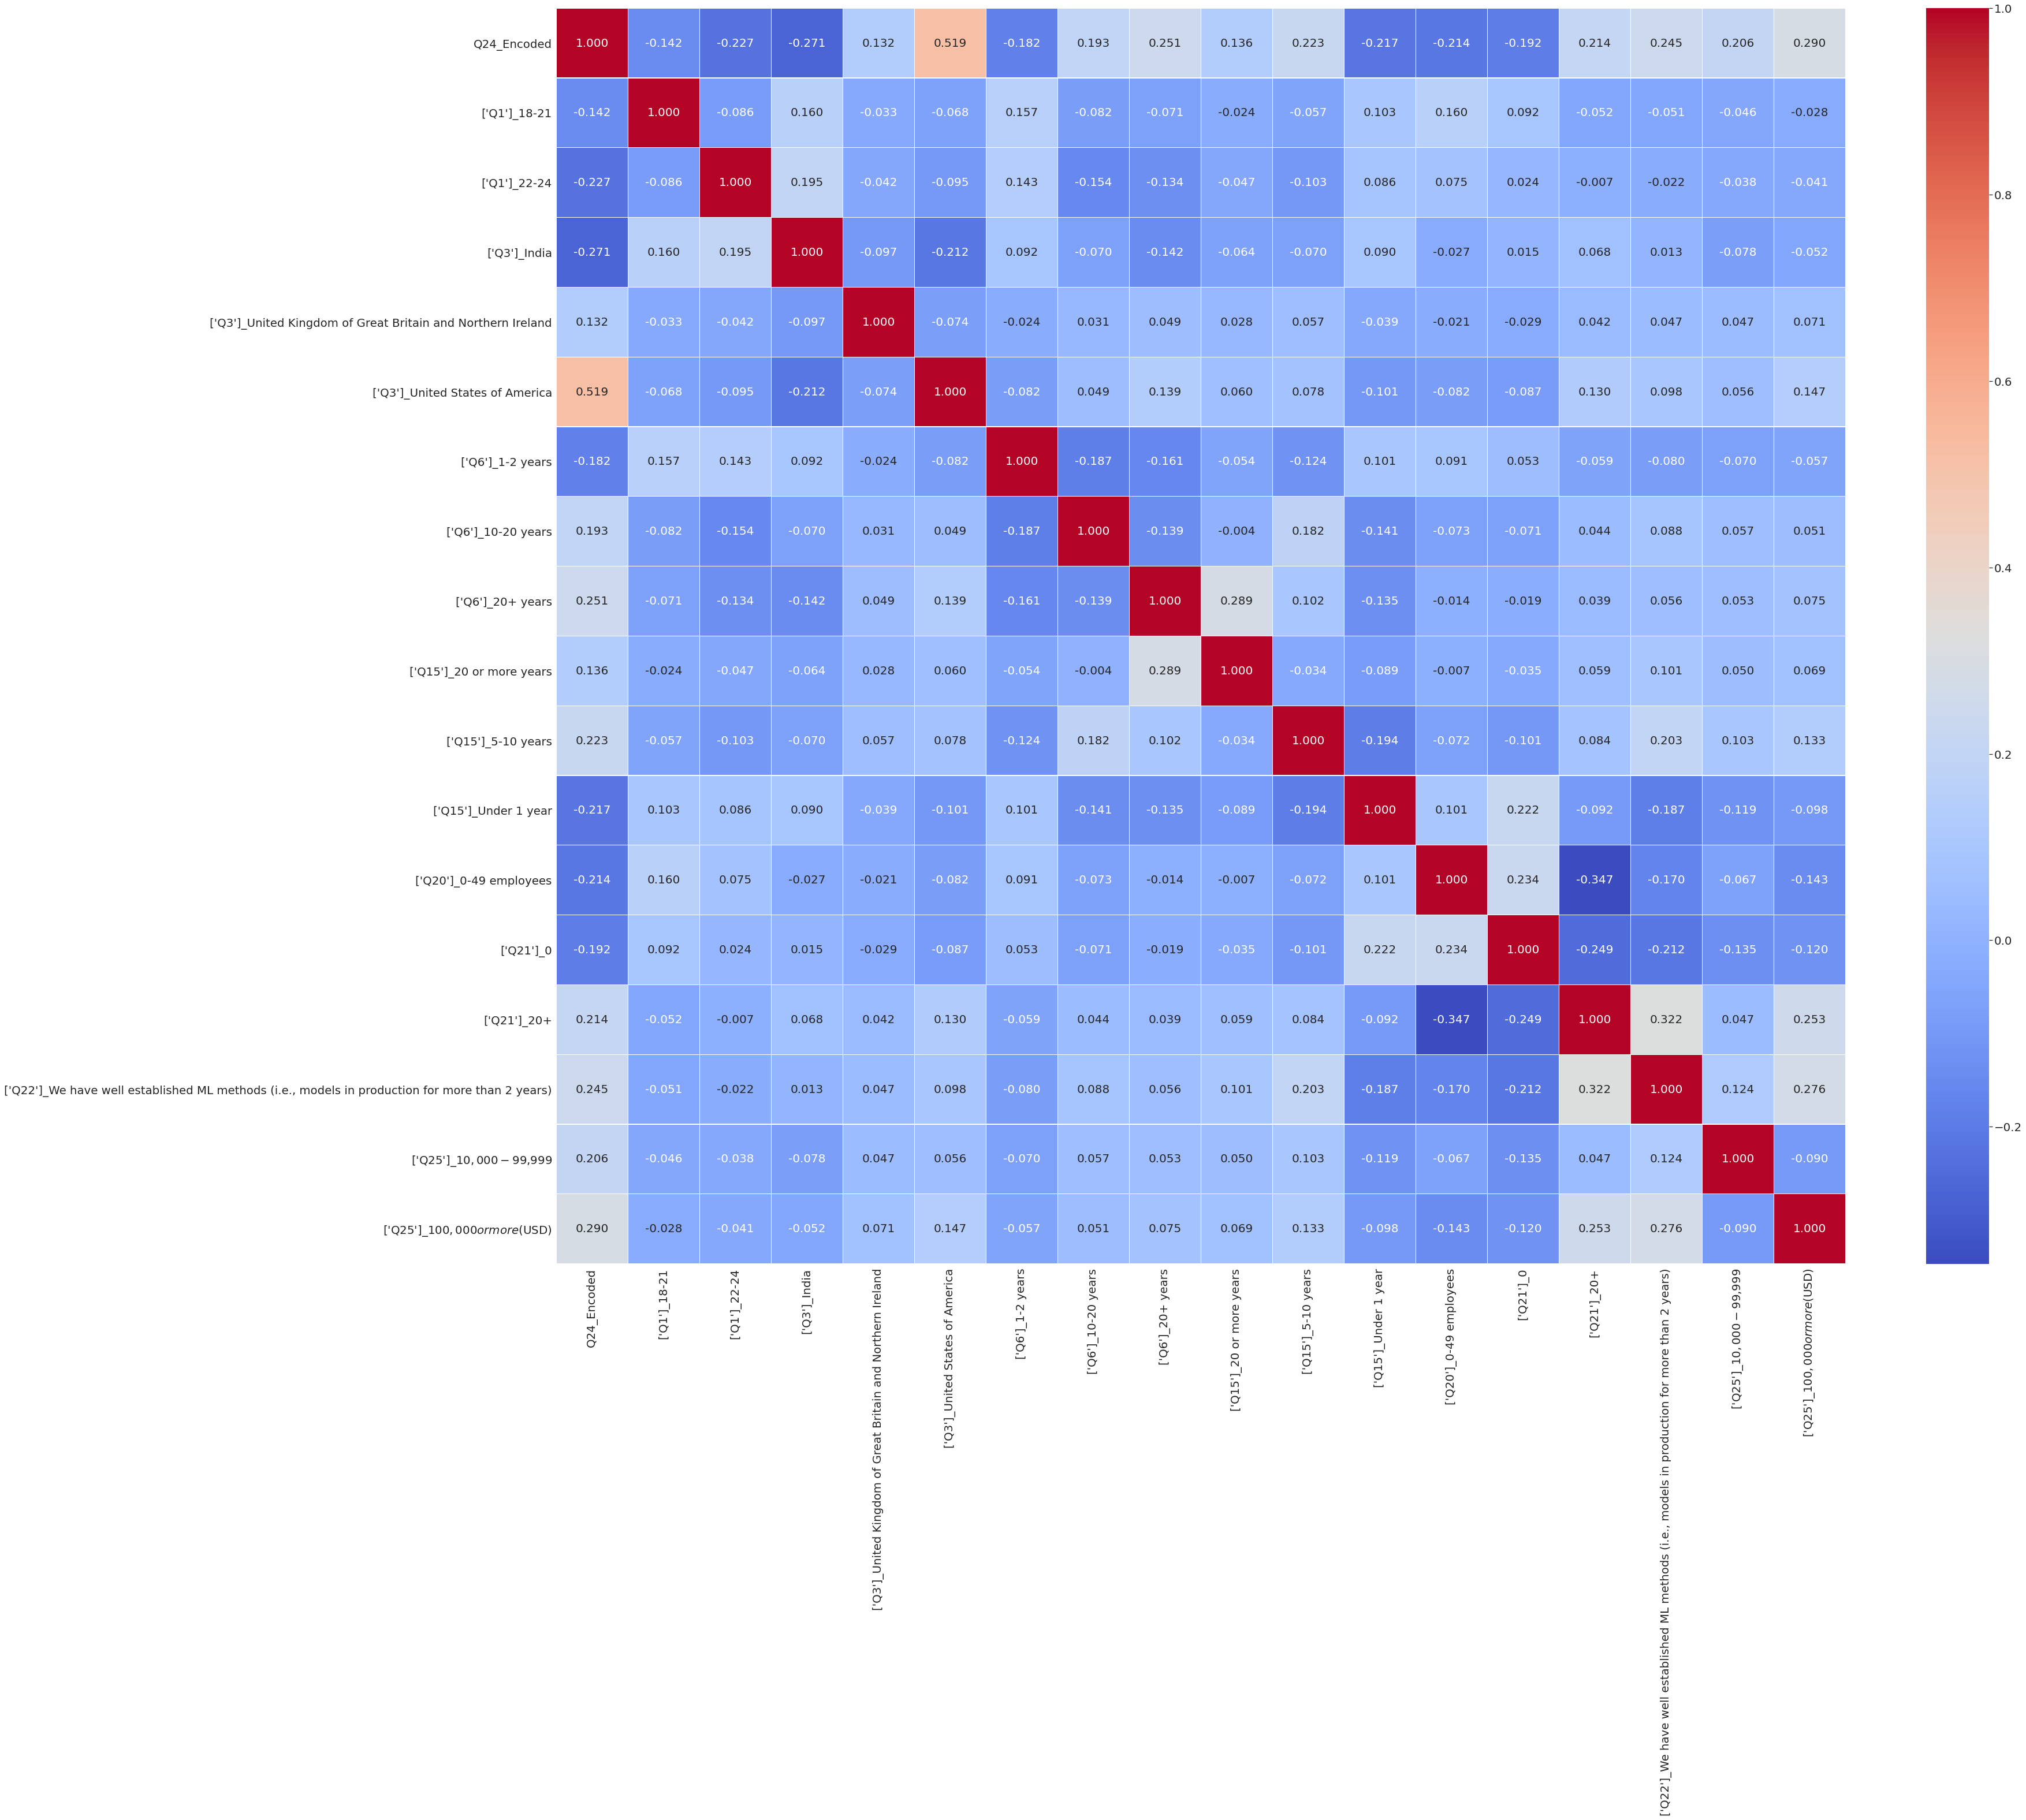

In [26]:
# Plot 2.6
plt.figure(figsize=(50,40))
sns.set(font_scale=1.8)
sns.heatmap(temp6.corr(),annot=True,cmap='coolwarm',linewidths=0.2,annot_kws={'size':20},fmt=".3f")
plt.tick_params(length=4)
plt.show()

From exploratory analysis, Q1 age and Q6 professional experience shows trends with salary. We can also see that part of Q1 and Q6 are also chosen for the most significant features after chi-square selection. The heatmap shows Q3 US has the highest correlation with salary, which is also ranked the highest from the chi-square test.

## Model Implementation

Step 1: Split data into X and y.

In [27]:
temp7 = temp6.copy()

y = temp7['Q24_Encoded']
temp7.drop(temp7.columns[temp7.columns.get_loc('Q24_Encoded')], axis = 1, inplace = True)

X = temp7

Step 2: Split data into 70% training data and 30% test data.

In [28]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=100)

Step 3: Build a class for ordinal logistic regression model

In [29]:
class ordlogreg(LogisticRegression):
    
    def __init__(self, penalty='l2', max_iter=100, C=1, cv=10):
        """
        Initiate the ordinal logistic regression model with default 
        setting as l2 penalty, 100 maximum interations, C value as 1 
        and 10 fold cross validation.
        """
        self.penalty = penalty
        self.max_iter = max_iter
        self.C = C
        self.cv = cv
        self.models = []
        self.change = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 13:13, 14:14}
        self.acc = []
        
    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, Y):
        """ 
        Build ordinal logistic regression by substracting predicted 
        probablity between each binary logistic regression on 15 salary 
        buckets from 0 to 14.
        """
        encoding = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
        presa = KFold(n_splits = 10).split(X,Y) # set up 10 folds cross validation
        modeli = []
        acc = []
        
        for a,b in presa:
            mnew = []
            fnew = []
            # loop over 14 combinations of salary buckets
            for t in range(0, len(Y.unique())-1):
                # encode each salary bucket into 1 and 0 for the rest of the buckets
                Y1 = [1 if x in encoding[:t+1] else 0 for x in Y] 
                
                # build logistic regression bewteen X and Y encoded in binary format
                m = LogisticRegression(solver = 'saga', penalty = self.penalty, 
                                       max_iter = self.max_iter, C = self.C, 
                                       random_state = 0).fit(X.iloc[a,:], np.array(Y1)[a]) 
                
                # append the new built logistic regression model into mnew list
                mnew.append(m) 
    
            modeli.append(mnew) 
            
            # make empty series based on the testing fold dimensions 
            matf = []
            matf.append(pd.Series(np.zeros(X.iloc[b,:].shape[0]))) 
            
            # predict probability based on previous binary logistic regression models from mnew list 
            for u in mnew:
                matf.append(pd.Series(u.predict_proba(X.iloc[b,:])[:,1]))
            
            # append a series of 1s as the last column in matf in order for subractions between columns later
            matf.append(pd.Series(np.ones(X.iloc[b,:].shape[0])))
            
            # take the difference between the columns and their following columns 
            # in order to get exact probablity of each salary bucket, then take 
            # the absolute value since some differences may be negative.
            # eliminate the last column of NaN. Based on probablity, 
            # get the index of the maximum probability 
            est = pd.concat(matf, axis=1).diff(periods=-1, axis=1).abs().iloc[:,:15].idxmax(axis=1)
            
            # Map to the previous dictionary of salary buckets
            Y1 = pd.Series(np.array(Y)[b]).map(self.change)
            
            # compare the true salary bucket with the predicted bucket to get accuracy
            acc.append(accuracy_score(Y1, est))
        
        self.acc = acc
        self.models = modeli[acc.index(max(acc))]  

    def predict_proba(self, X):
        """ 
        Return the predicted probablity on each salary bucket from X
        """
        matf = []
        matf.append(pd.Series(np.zeros(X.shape[0])))
        for u in self.models:
                matf.append(pd.Series(u.predict_proba(X)[:,1]))
        matf.append(pd.Series(np.ones(X.shape[0])))
        est = pd.concat(matf, axis=1).diff(periods=-1, axis=1).abs().iloc[:,:15]
        return (est) 

    def predict(self, X):
        """ 
        Return the predicted salary bucket from X
        """
        est = self.predict_proba(X).idxmax(axis=1)
        return(est)

Step 4: Set up a model and fit to the train data to find the accuracy of each fold, mean accuracy and variance from 10 folds 

In [30]:
lr = ordlogreg()
lr.fit(X_train, Y_train)
print(lr.acc)
# [0.4633821571238349, 0.4394141145139814, 0.43275632490013316, 0.4647137150466045, 0.40346205059920104, 
# 0.41544607190412786, 0.41145139813581894, 0.44607190412782954, 0.4620505992010652, 0.4207723035952064]

[0.4633821571238349, 0.4394141145139814, 0.43275632490013316, 0.4647137150466045, 0.40346205059920104, 0.41544607190412786, 0.41145139813581894, 0.44607190412782954, 0.4620505992010652, 0.4207723035952064]


In [31]:
np.mean(lr.acc)
# 0.4359520639147803

0.4359520639147803

In [32]:
np.var(lr.acc)

0.0004692190262074002

The Accuracies from 10 folds are listed above. The mean accuracy of the 10 folds is around 43.595%. The variance is around 0.000469. The variance is very small between each fold, but the accuracy is not very high meaning there exist a bias between the model and the true target variable values.

## Model Tuning

Step 1: The two hyperparameters are chosen for tuning are the penalty term (l1 & l2) and C values.
Step 1: Using grid search to try 10 values from logspace -2 to 2. Due to long running time, we first try 10 values with l1, 10 values with l2, and then 10 values with both l1 and l2 together to find the optimal hyperparamters combination.

In [38]:
# for TA running this in shorter time, only test 1 value in C. 
# Cog lab finishes one C value in 7 mins - result {'C': 0.01, 'penalty': 'l2'}
par_grid = {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2,1)} 
gs = GridSearchCV(ordlogreg(), par_grid, scoring='accuracy')
print(gs.fit(X_train,Y_train).best_params_)
# the output is from {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2,10)}

# {'penalty':['l1'], 'C': np.logspace(-2,2,10)} cv = 10 -> {'C': 0.21544346900318834, 'penalty': 'l1'}
# {'penalty':['l2'], 'C': np.logspace(-2,2,10)} cv = 10 -> {'C': 0.21544346900318834, 'penalty': 'l2'}
# {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2,10)} cv = 10 -> {'C': 0.21544346900318834, 'penalty': 'l1'} - 25 mins
# {'penalty':['l1', 'l2'], 'C': [0.21544346900318834]} cv = 10 -> {'C': 0.21544346900318834, 'penalty': 'l1'} - 4 mins

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  -------


{'C': 0.21544346900318834, 'penalty': 'l1'}


No matter searching C values with the l1 and l2 seperately or altogether, the optimal C from grid search is always 0.21544346900318834. And grid search determine l1 to be the optimal penalty compared to l2.

Step 2: Using random search to try 10 values (default setting) from logspace -2 to 2. Due to long running time, we first try 10 values with l1, 10 values with l2, and then 10 values with both l1 and l2 together to find the optimal hyperparamters combination. Since our dataset is very large, the running time is also very long and our model is also complex. Compare to grid search, random search may be a more efficient tool to find an optimal C value (randomally selected from the logspace -2 to 2) with one of the penalty.

In [41]:
# for TA running this in shorter time, only test 1 value in C. 
# Cog lab finishes one C value in 7.5 mins - result {'penalty': 'l2', 'C': 0.01}
par_grid = {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2,1)}
rs = RandomizedSearchCV(ordlogreg(), par_grid, scoring='accuracy', random_state=7)
print(rs.fit(X_train,Y_train).best_params_)
# the output is from {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2)}

# {'penalty':['l1'], 'C': np.logspace(-2,2)} cv = 10 -> {'penalty': 'l1', 'C': 0.1151395399326447} - 16 mins
# {'penalty':['l2'], 'C': np.logspace(-2,2)} cv = 10 -> {'penalty': 'l2', 'C': 0.16768329368110074} - 13 mins
# {'penalty':['l1', 'l2'], 'C': np.logspace(-2,2)} cv = 10 -> {'penalty': 'l2', 'C': 0.0372759372031494} - 25 mins

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  -------


{'penalty': 'l2', 'C': 0.0372759372031494}


When only search 10 random C values with l1, the optimal C value is 0.1151395399326447. The optimal C value is 0.16768329368110074 only with l2. The optimal C values searched including both l1 l2, the optimal hyperparameter combination is l2 with C = 0.0372759372031494.

Step 3: Compare all potential optimal hyperparameter combinations.

In [35]:
lr = ordlogreg(penalty = 'l2', C = 0.0372759372031494)
lr.fit(X_train, Y_train)
print('accruacy: ', lr.acc, 
      '\nmean accuracy: ', np.mean(lr.acc), 
      '\naccuracy variance: ', np.var(lr.acc))

# penalty = 'l1', C = 0.21544346900318834
# accruacy:  [0.4633821571238349, 0.4394141145139814, 0.43275632490013316, 0.46604527296937415, 0.40878828229027964, 
#             0.4141145139813582, 0.41145139813581894, 0.4447403462050599, 0.46604527296937415, 0.4194407456724368] 
# mean accuracy:  0.43661784287616506 
# accuracy variance:  0.00047462681803755633

# penalty = 'l2', C = 0.21544346900318834
# accruacy:  [0.4633821571238349, 0.4394141145139814, 0.43009320905459386, 0.46604527296937415, 0.40878828229027964, 
#             0.41278295605858856, 0.41145139813581894, 0.4434087882822903, 0.4607190412782956, 0.422103861517976] 
# mean accuracy:  0.43581890812250335 
# accuracy variance:  0.00044398857448834294

# penalty = 'l1', C = 0.1151395399326447
# accruacy:  [0.4620505992010652, 0.4380825565912117, 0.4340878828229028, 0.46870838881491345, 0.40612516644474034, 
#             0.41544607190412786, 0.41145139813581894, 0.4434087882822903, 0.4620505992010652, 0.4207723035952064] 
# mean accuracy:  0.43621837549933423 
# accuracy variance:  0.00046389988670232814

# penalty = 'l2', C = 0.16768329368110074
# accruacy:  [0.4633821571238349, 0.440745672436751, 0.43275632490013316, 0.46870838881491345, 0.40878828229027964, 
#             0.41145139813581894, 0.41278295605858856, 0.4434087882822903, 0.4647137150466045, 0.4234354194407457] 
# mean accuracy:  0.437017310252996 
# accuracy variance:  0.0004761693684940272

# penalty = 'l2', C = 0.0372759372031494
# accruacy:  [0.4647137150466045, 0.4434087882822903, 0.440745672436751, 0.459387483355526, 0.40745672436750996, 
#             0.4167776298268975, 0.41145139813581894, 0.4434087882822903, 0.46604527296937415, 0.4207723035952064] 
# mean accuracy:  0.4374167776298269 - Best
# accuracy variance:  0.00044051340334502943

accruacy:  [0.4647137150466045, 0.4434087882822903, 0.440745672436751, 0.459387483355526, 0.40745672436750996, 0.4167776298268975, 0.41145139813581894, 0.4434087882822903, 0.46604527296937415, 0.4207723035952064] 
mean accuracy:  0.4374167776298269 
accuracy variance:  0.00044051340334502943


In the comment above, all potential optimal hyperparameter combinations are checked using accuracy. The last comination made from random search on both l1 and l2 with 10 C values shows the optimal combination of l2 with C = 0.0372759372031494.

Step 4: Plot Validation Curve to examine changes model score with l2 and 10 different C values 

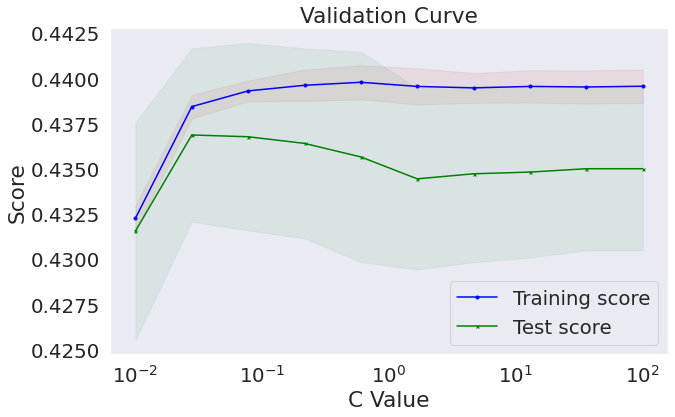

In [36]:
# Plot 4.1
# This hyperparameter C tuning can be visualized by a validation curve (test set vs validation set)
# cog lab takes more than 1 hour to plot 10 C values with l2 (c_list = np.logspace(-2,2,10))
# for traning and test data(see output below).

# for TA running this in shorter time, only 2 Cs will be used to plot, 
# which takes around 18 mins to finish plotting (different from the output)
c_list = np.logspace(-2,2,2)

lr = ordlogreg(penalty = 'l2')

train_scores, test_scores = validation_curve(estimator = lr, X=X, y=y, param_name='C', param_range=c_list, cv=10)

plt.figure(figsize=(10,6))
plt.title('Validation Curve')

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.grid()
plt.fill_between(c_list, train_mean - train_std,\
                 train_mean + train_std, alpha=0.1, \
                 color="r")
plt.fill_between(c_list, test_mean - test_std,\
                 test_mean + test_std, alpha=0.1, color='g')

plt.plot(c_list, train_mean, color='blue', marker='o', markersize=3, label='Training score')
plt.plot(c_list, test_mean, color='green', marker='x', markersize=3, label='Test score') 
plt.xscale('log')
plt.xlabel('C Value')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()

According to the validation curve plot (Plot 4.1) using l2 with 10 Cs, the training data accuracy became stable around C = 0.05, but the test data accuracy decreased after that point. When C became larger, the model was overfitting the training dataset and underfitting the test data, thereby causing test data accuracy dropped significantly after C = 0.05. It is better to choose a C value that offers a good accuracy on training but also on test data set addressing the bias-variance tradeoff, 0.037 seems to be a good choice for model tuning.

### Model Validation

Confusion Matrix evaluate how well the model predicts and compare with true variable values.

In [33]:
# Plot 5.1
# Plot Multi-class Confusion Matrix
# Jalal, M (2018) sklearn plot confusion matrix with labels. 
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.6)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r', annot_kws={'size':14},)
    #plt.savefig(filename)
    plt.show()

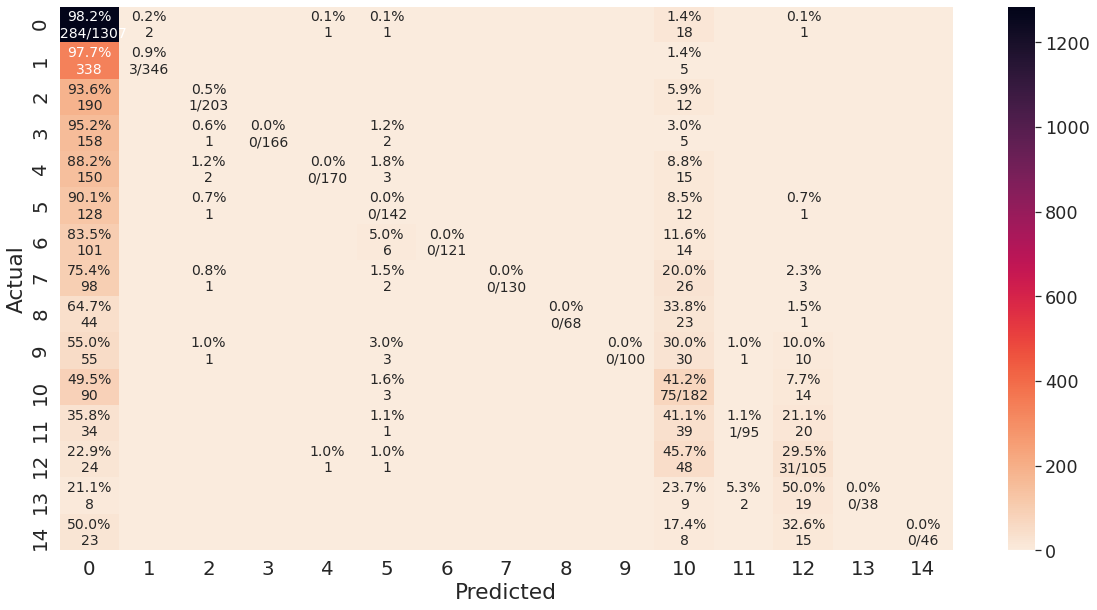

In [34]:
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
olr = ordlogreg(penalty = 'l2', C = 0.0372759372031494)
olr.fit(X_train, Y_train)
y_pred = olr.predict(X_test)
cm_analysis(Y_test, y_pred, labels, ymap=None, figsize=(20,10))

The prediction is very accurate on bucket 0 (98.2%), medium accuracy on 10 (41.2%) and 12 (29.5%). It mis predicted all salary buckets as 0, this might be because most of the actual data were allocated in 0 salary bucket according to the exploratory data. We can also see that this model cannot differentiate the difference between buckets that are close together. It miscategorized 7,8,9,11,12,13 all as 10, and also miscategorized 11,13,14 as 12. Features selected could only differentiate data in a more general way, but not accurate enough to predict the exact bucket category.

In [43]:
print(classification_report(Y_test, olr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.47      0.98      0.64      1307
         1.0       0.60      0.01      0.02       346
         2.0       0.14      0.00      0.01       203
         3.0       0.00      0.00      0.00       166
         4.0       0.00      0.00      0.00       170
         5.0       0.00      0.00      0.00       142
         6.0       0.00      0.00      0.00       121
         7.0       0.00      0.00      0.00       130
         8.0       0.00      0.00      0.00        68
         9.0       0.00      0.00      0.00       100
        10.0       0.22      0.41      0.29       182
        11.0       0.25      0.01      0.02        95
        12.0       0.27      0.30      0.28       105
        13.0       0.00      0.00      0.00        38
        14.0       0.00      0.00      0.00        46

   micro avg       0.43      0.43      0.43      3219
   macro avg       0.13      0.11      0.08      3219
weighted avg       0.29   

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


Precision, recall and f1-score are all very high on category 0, follwed by category 12 and 10.

According to Q5, we need to plot the distribution of true target variable with training and test data.
The first plot is the histogram with prections on training X data labelled in blue and true target variable value (also as training Y data) in red. Our model predicts most salary buckets on category 0 and 10, a little bit on category 12. The reason why we only reach around 44 accuracy is that the model cannot differentiate the differences between 0 and other categories. More data is needed from other salary buckets.

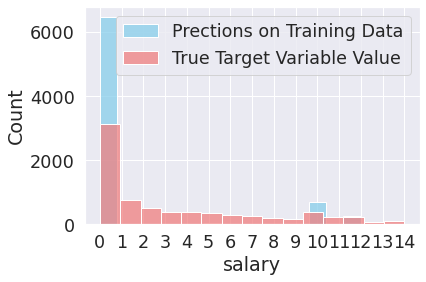

In [35]:
# Plot 5.2
pred = pd.DataFrame(olr.predict(X_train))
pred.columns = ['salary']

y_tr = pd.DataFrame(Y_train.copy())
y_tr.columns = ['salary']

ax1 = sns.histplot(pred['salary'], color="skyblue", bins = 15, label="Prections on Training Data")
ax2 = sns.histplot(y_tr['salary'], color="lightcoral", bins = 15, label="True Target Variable Value")

ax1.set_xticks(range(15))
ax1.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax2.set_xticks(range(15))
ax2.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.legend()

A similar trend appears in the distribution of salary predictions (Plot 5.3) on test X data and true test salary. Because most of the data are from salary bucket 0 and fewer data from other categories, the model can only distinguish between buckets 0 and 10 from the 17 features selected, but more significant features and more data from other salary buckets except 0 are needed to differentiate salary buckets that are closer together to have higher accuracy.

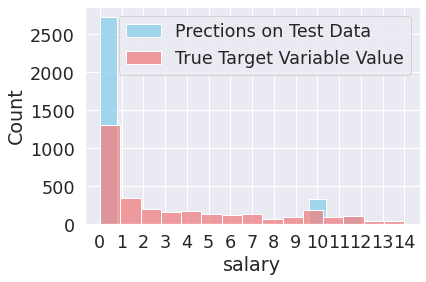

In [39]:
# Plot 5.3
pred = pd.DataFrame(olr.predict(X_test))
pred.columns = ['salary']

y_tr = pd.DataFrame(Y_test.copy())
y_tr.columns = ['salary']

ax1 = sns.histplot(pred['salary'], color="skyblue", bins = 15, label="Prections on Test Data")
ax2 = sns.histplot(y_tr['salary'], color="lightcoral", bins = 15, label="True Target Variable Value") # comment this to see clearly where the blue bars are

ax1.set_xticks(range(15))
ax1.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax2.set_xticks(range(15))
ax2.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.legend()

Lastly, the predict salary from X test and combined with the true target variables. Then plot histogram of how the predictions look like on each true target variable bucket. For example, the first plot represents the prediction distribution for true salary bucket 0. Most of the cases are predicted correctly, but still there are few cases mis-categorize into 10 and 12. Similar to other true salary bucket categories, most of the cases are mis-predicts into 0 

salary_true
0.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
7.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
8.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
9.0     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
10.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
11.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
12.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
13.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
14.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

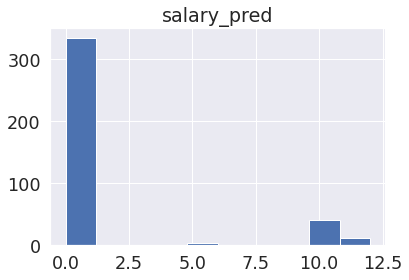

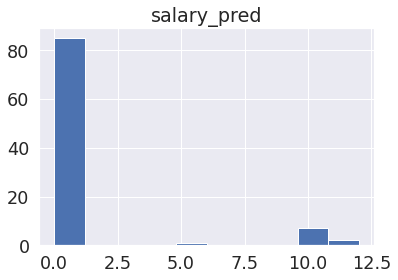

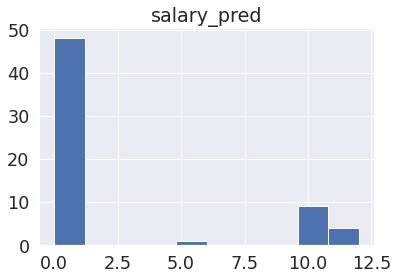

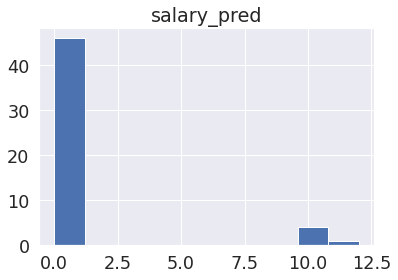

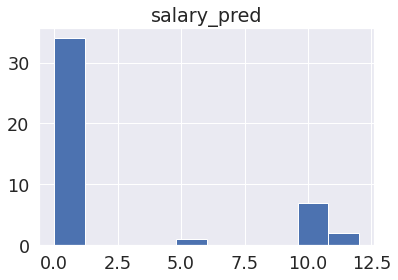

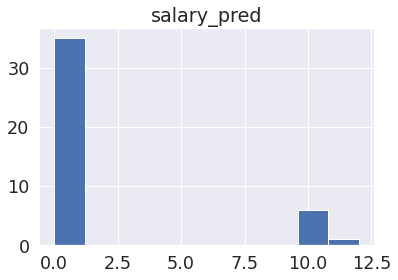

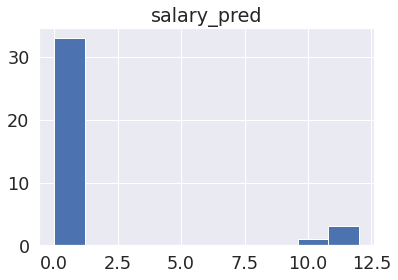

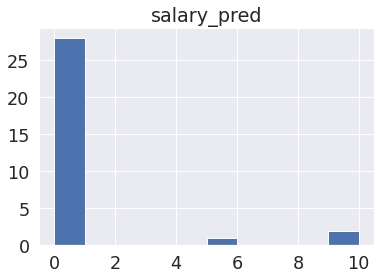

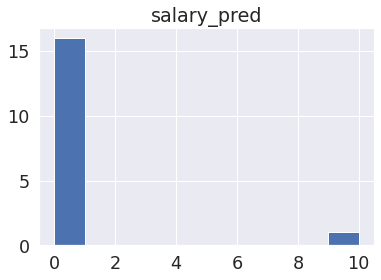

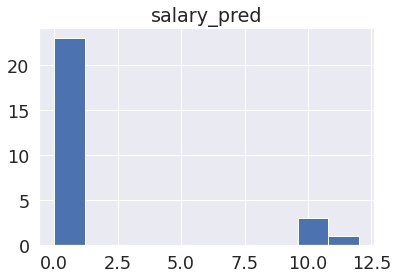

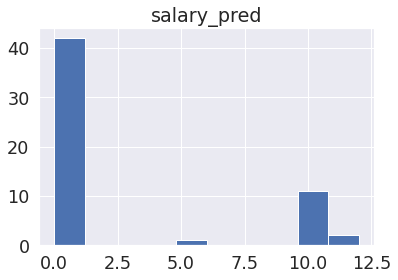

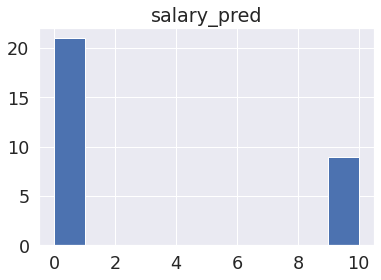

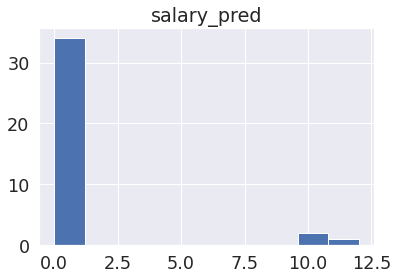

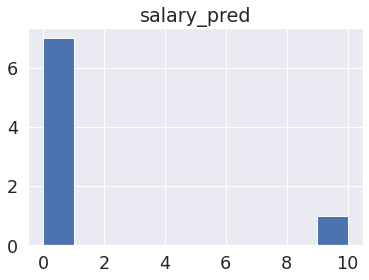

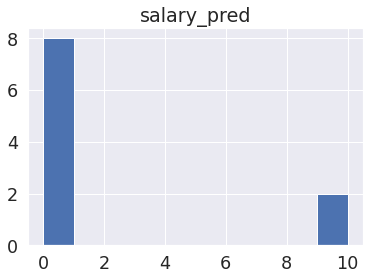

In [45]:
# Plot 5.4
pred = pd.DataFrame(olr.predict(X_test))
pred.columns = ['salary_pred']

y_tr = pd.DataFrame(Y_test.copy())
y_tr.columns = ['salary_true']

merged = pred.merge(y_tr, left_index=True, right_index=True, how='inner')

merged.head()

merged.groupby(['salary_true']).hist()